In [1]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

from scipy.sparse import hstack

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


In [5]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [6]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

### 1. Случайный лес

In [7]:
# Обучим случайный лес
from sklearn.ensemble import RandomForestClassifier

classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier()),
])

In [8]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7737892138308946+-0.007018615938970261


In [9]:
#Посчитаем precision/recall/f_score
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350000, F-Score=0.721, Precision=0.645, Recall=0.817


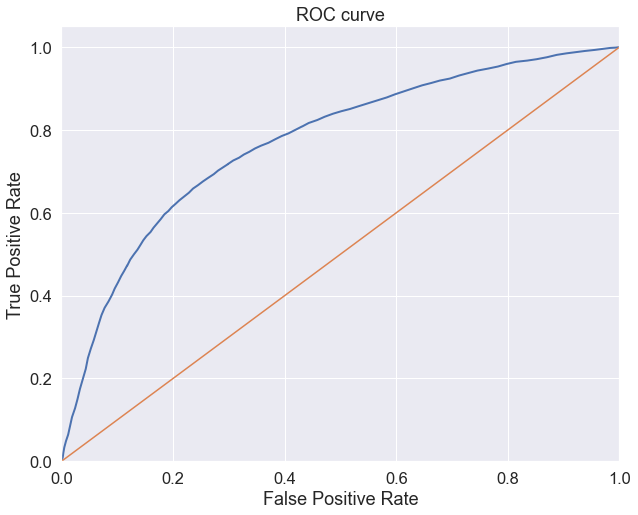

In [10]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [11]:
rocauc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
lgls = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(rocauc))
print("log loss score: {}".format(lgls))

roc auc score: 0.7701486266549631
log loss score: 0.6132182154620344


In [12]:
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8084101382488479, 0.43140589569161, 0.56859410430839)

In [13]:
precision_rf = precision[ix]
recall_rf = recall[ix]
rocauc_rf = rocauc
fscore_rf = fscore[ix]
df_compare = pd.DataFrame([["Random forest", precision_rf, recall_rf, rocauc_rf, fscore_rf]], 
columns=['method','precision', 'recall', 'roc auc', 'f score'])
df_compare

,method,precision,recall,roc auc,f score
0,Random forest,0.644806,0.816705,0.770149,0.720647


### 2. Градиентный бустинг

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

classifier = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)),
])

In [15]:
#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7971946542696801+-0.0069185562168582624


In [16]:
#Посчитаем precision/recall/f_score
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.358156, F-Score=0.739, Precision=0.679, Recall=0.810


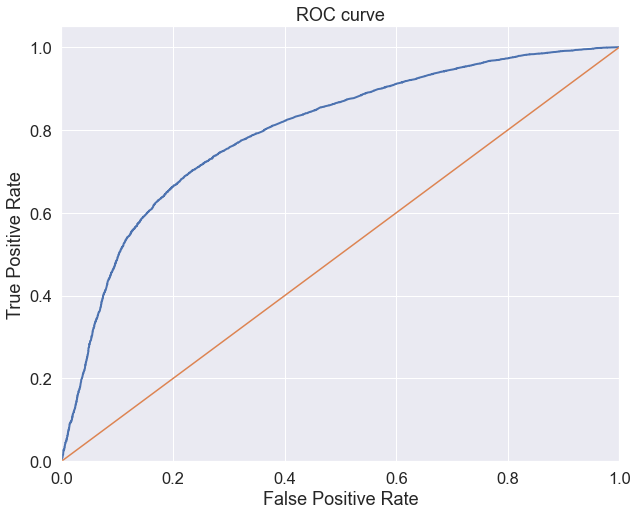

In [17]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [18]:
rocauc = roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])
lgls = log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])
print("roc auc score: {}".format(rocauc))
print("log loss score: {}".format(lgls))

roc auc score: 0.7964637018401831
log loss score: 0.5507320527457711


In [19]:
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.8099078341013825, 0.37777777777777777, 0.6222222222222222)

In [20]:
new_row = {'method':'Gradient boosting', 'precision':precision[ix], 'recall':recall[ix], 'roc auc':rocauc, 'f score':fscore[ix]}
df_compare = df_compare.append(new_row, ignore_index=True)

#добавим еще данные по логистической регрессии
new_row = {'method':'Logistic Regression', 'precision':0.647, 'recall':0.838, 'roc auc':0.7840347790421852, 'f score':0.730}
df_compare = df_compare.append(new_row, ignore_index=True)

df_compare

,method,precision,recall,roc auc,f score
0,Random forest,0.644806,0.816705,0.770149,0.720647
1,Gradient boosting,0.678503,0.810138,0.796464,0.738500
2,Logistic Regression,0.647000,0.838000,0.784035,0.730000


В целом градиентный бустинг дает лучшие метрики чем случайный лес и логистическая регрессия, за исключением recall. Если нам важнее определить побольше класса 1, то логистическая регрессия показала лучший результат

### 5. (опциональный вопрос)

какой график (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого, например, 1 к 1000).
p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно).
Допустим, у нас две модели:

первая помечает 100 объектов как класс 1, но TP = 90
вторая помечает 1000 объектов как класс 1, но TP такой же - 90
Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

В 1-ой модели precision = 90(90+10) = 0.9  FPR = 10/99900 = 0.0001 
Во 2-ой модели precision = 90(90+910) = 0.09  FPR = 910/99900 = 0.009 
при этом recall у них одинаковый на графике precision_recall_curve модель 1 будет значительно выше 2-ой
recall = TPR
на графике  roc_auc_curve точки 0.0001 и 0.009 по оси x очень близко. Визуально разницу можно не заметить